In [138]:
import pandas
import numpy as np
from sklearn import metrics
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cross_validation import ShuffleSplit, KFold, cross_val_score, StratifiedKFold, \
                                     StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2

import matplotlib.pyplot as plt
%matplotlib inline

# Критерии качества моделей

Доска:

критерии качества

метрики качества

Рассмотрим датасет http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

In [49]:
data = load_boston()
data.data = scale(data.data)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3)

regr = Ridge().fit(X_train, y_train)
pred = regr.predict(X_test)

print('MSE:\t%.3f' % metrics.mean_squared_error(y_test, pred))
print('MAE:\t%.3f' % metrics.mean_absolute_error(y_test, pred))
print('R2:\t%.3f' % metrics.r2_score(y_test, pred))

MSE:	22.803
MAE:	3.278
R2:	0.751


Как распределена ошибка по объектам?

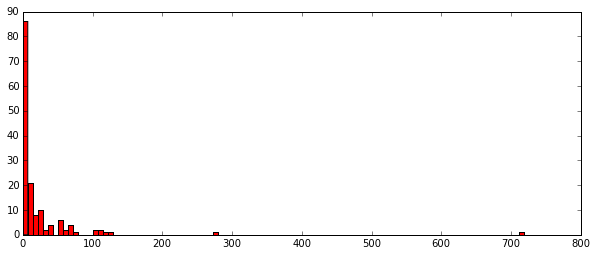

In [50]:
quad_errors = (pred - y_test) ** 2

plt.figure(figsize=(10, 4))
plt.hist(quad_errors, bins=100, color='red')
plt.show()

### Метрики качества классификации

In [141]:
def analyse(clf, X_test, y_test):
    predict = clf.predict(X_test)
    predict_prob = clf.predict_proba(X_test)[:, 1]

    print('Accuracy:\t%.3f' % metrics.accuracy_score(y_test, predict))
    print('Accuracy of constant classifier: %.3f' % metrics.accuracy_score(y_test, np.zeros(y_test.shape)))
    print('Precision:\t%.3f' % metrics.precision_score(y_test, predict))
    print('Recall:\t\t%.3f' % metrics.recall_score(y_test, predict))
    print('F1:\t\t%.3f' % metrics.f1_score(y_test, predict))
    print('AUC-ROC:\t%.3f' % metrics.roc_auc_score(y_test, predict_prob))
    print('AUC-PR:\t\t%.3f' % metrics.average_precision_score(y_test, predict_prob))
    print(metrics.classification_report(y_test, predict))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_prob)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, lw=2)
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)
    plt.show()
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, predict_prob)
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, lw=2)
    plt.xlabel('recall', fontsize=16)
    plt.ylabel('precision', fontsize=16)
    plt.show()

THE CARAVAN INSURANCE DATA

http://kdd.ics.uci.edu/databases/tic/tic.html

Задача: предсказать, купит ли человек страховку.
Данные несбалансированные — мало кто покупает страховку

In [142]:
data = pandas.read_csv('http://kdd.ics.uci.edu/databases/tic/ticdata2000.txt', sep='\t', header=None)
data.iloc[:, -1].value_counts()

0    5474
1     348
Name: 85, dtype: int64

In [143]:
X_train, X_test, y_train, y_test = train_test_split(scale(data.iloc[:, 1:-1].astype(np.float)),
                                                    data.iloc[:, -1],
                                                    test_size=0.3)

Доля, купивших страховку на обучении и на тесте

In [144]:
print('%.3f' % np.mean(y_train), '%.3f' % np.mean(y_test))

0.061 0.058


Accuracy:	0.941
Accuracy of constant classifier: 0.942
Precision:	0.375
Recall:		0.030
F1:		0.055
AUC-ROC:	0.699
AUC-PR:		0.139
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1646
          1       0.38      0.03      0.06       101

avg / total       0.91      0.94      0.92      1747



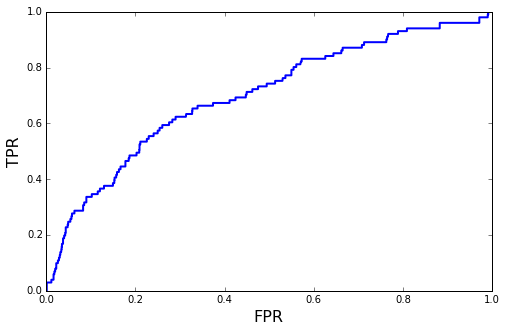

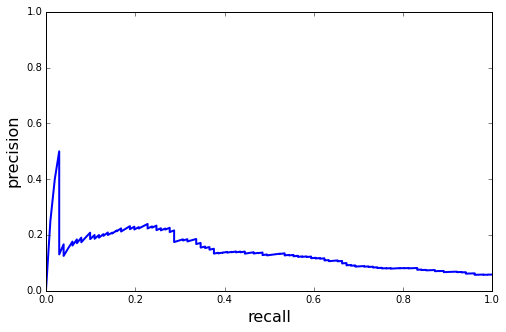

In [145]:
analyse(LogisticRegression().fit(X_train, y_train), X_test, y_test)

#### Попробуем RandomForest

Accuracy:	0.929
Accuracy of constant classifier: 0.942
Precision:	0.074
Recall:		0.020
F1:		0.031
AUC-ROC:	0.704
AUC-PR:		0.123
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      1646
          1       0.07      0.02      0.03       101

avg / total       0.89      0.93      0.91      1747



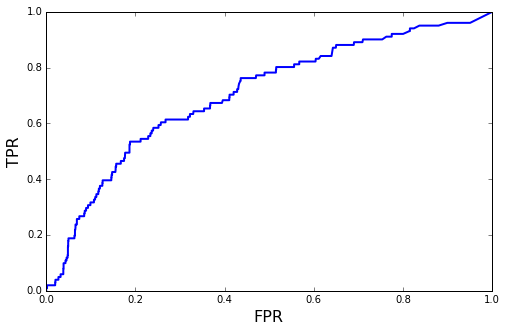

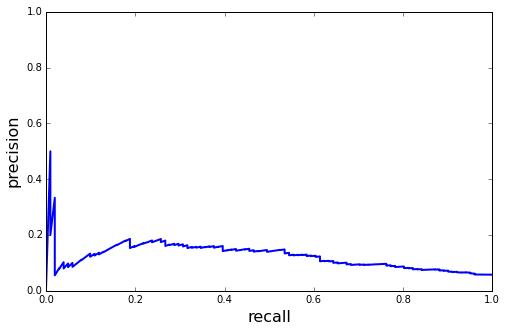

In [146]:
analyse(RandomForestClassifier(n_estimators=1000).fit(X_train, y_train), X_test, y_test)

(Random Forest не всегда лучше линейной модели)

### Кросс-валидация

In [120]:
data = load_boston()
data.data = scale(data.data)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3)

In [83]:
for k in np.arange(1, 10):
    regr = KNeighborsRegressor(n_neighbors=k, weights='distance').fit(X_train, y_train)
    pred = regr.predict(X_test)
    print('%d: %.3f' % (k, metrics.mean_squared_error(y_test, pred)))

1: 23.388
2: 27.015
3: 29.415
4: 32.498
5: 33.546
6: 32.868
7: 32.454
8: 32.266
9: 32.254


In [85]:
cv = ShuffleSplit(X_train.shape[0], n_iter=1, random_state=241, 
                  test_size=0.2)
for k in np.arange(1, 10):
    regr = KNeighborsRegressor(n_neighbors=k, weights='distance')
    print('%d: %.3f' % (k, -cross_val_score(regr, X_train, y_train, cv=cv, scoring='mean_squared_error')))

1: 27.626
2: 17.239
3: 16.455
4: 14.054
5: 13.186
6: 12.351
7: 12.386
8: 12.872
9: 13.157


In [133]:
def do_kfold(k, X_train, y_train, kfold=KFold, farg=None, model=KNeighborsRegressor,
             scoring='mean_squared_error', random_state=241, sign=-1):
    cv = kfold(farg if farg is not None else X_train.shape[0], n_folds=k, random_state=random_state)
    scores = np.zeros((k, 9))
    nn_values = np.arange(1, 10)
    
    for n_neighbors in nn_values:
        regr = model(n_neighbors=n_neighbors, weights='distance')
        scores[:, n_neighbors - 1] = sign * cross_val_score(regr, X_train, y_train, cv=cv, scoring=scoring)

    plt.figure(figsize=(8, 5))
    plt.fill_between(nn_values, scores.mean(axis=0) - scores.std(axis=0),
                     scores.mean(axis=0) + scores.std(axis=0), alpha=0.2)
    for j in range(k):
        plt.plot(nn_values, scores[j], alpha=0.5, color='b')
    plt.plot(nn_values, scores.mean(axis=0), color='r', lw=2)
    plt.xlabel('n_neighbors', fontsize=16)
    plt.ylabel('error', fontsize=16)
    plt.title('n_folds = %d' % k, fontsize=16)
    plt.show()

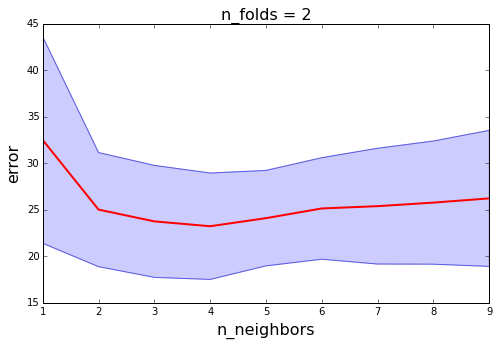

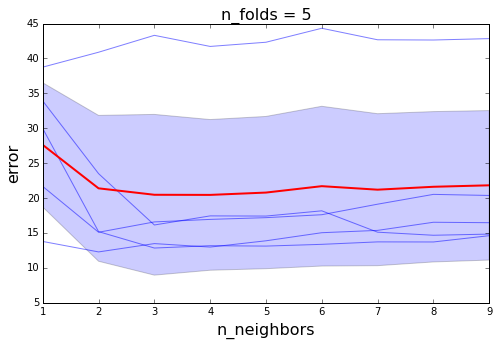

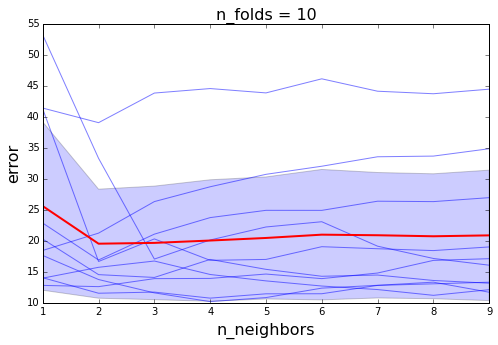

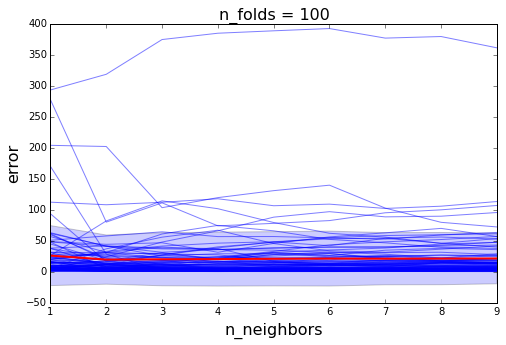

In [123]:
for k in [2, 5, 10, 100]:
    do_kfold(k, X_train, y_train)

Чем больше фолдов, тем меньше объектов попадает в контроль, тем менее надежно по нему оценивается качество — дисперсия растет

#### Другой датасет

In [127]:
data = pandas.read_csv('http://kdd.ics.uci.edu/databases/tic/ticdata2000.txt', sep='\t', header=None)
X_train, X_test, y_train, y_test = train_test_split(scale(data.iloc[:, 1:-1].astype(np.float)),
                                                    data.iloc[:, -1],
                                                    test_size=0.3)

In [115]:
search_range = np.arange(5, 71, 5)
for k in search_range:
    regr = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(X_train, y_train)
    pred = regr.predict_proba(X_test)[:, 1]
    print('%d: %.3f' % (k, metrics.roc_auc_score(y_test, pred)))

5: 0.585
10: 0.635
15: 0.642
20: 0.653
25: 0.657
30: 0.654
35: 0.651
40: 0.656
45: 0.656
50: 0.651
55: 0.651
60: 0.649
65: 0.645
70: 0.646


In [116]:
cv = StratifiedShuffleSplit(y_train, n_iter=1, random_state=241, test_size=0.3)
for k in search_range:
    regr = KNeighborsRegressor(n_neighbors=k, weights='distance')
    print('%d: %.3f' % (k, -cross_val_score(regr, X_train, y_train, cv=cv, scoring='mean_squared_error')))

5: 0.068
10: 0.064
15: 0.062
20: 0.061
25: 0.060
30: 0.060
35: 0.059
40: 0.059
45: 0.059
50: 0.059
55: 0.058
60: 0.058
65: 0.058
70: 0.058


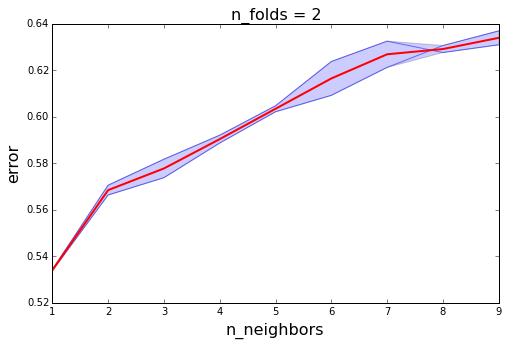

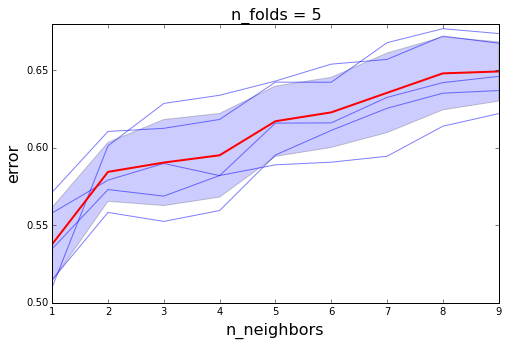

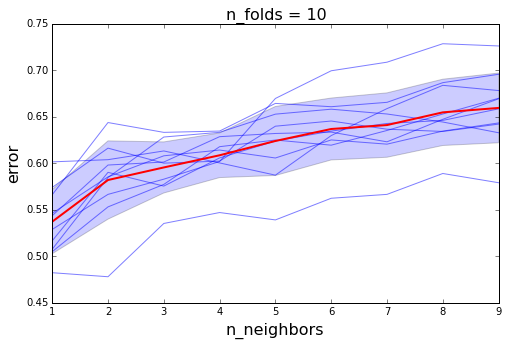

In [134]:
for k in [2, 5, 10]:
    do_kfold(k, X_train, y_train, kfold=StratifiedKFold, farg=y_train,
             model=KNeighborsClassifier, scoring='roc_auc', sign=1)

# Отбор признаков

В наших примерах мы будем работать с набором данных, содержащим информацию о случаях сахарного диабета среди индейцев Пима (Pima Indians diabetes). Все признаки являются числовыми, а задача представляет собой двухклассовую классификацию.

### Одномерный отбор признаков

In [135]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
dataframe.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


В примере ниже используется критерий хи-квадрат (chi-squared test) для неотрицательных признаков, чтобы отобрать 4 лучших признака. Возможно использовать и другие критери. 

In [139]:
# feature extraction

test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# summarize scores

print(fit.scores_)


[  111.51969064  1411.88704064    17.60537322    53.10803984  2175.56527292
   127.66934333     5.39268155   181.30368904]


Мы видим оценки для каждого признака и 4 отобранных признака (с наивысшими оценками): plas, test, mass и age.

In [140]:
features = fit.transform(X)

# summarize selected features

print(features[:,:])

[[ 148.     0.    33.6   50. ]
 [  85.     0.    26.6   31. ]
 [ 183.     0.    23.3   32. ]
 ..., 
 [ 121.   112.    26.2   30. ]
 [ 126.     0.    30.1   47. ]
 [  93.     0.    30.4   23. ]]


#### Проверим качество различных моделей при использовании данного набора признаков

In [51]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_2=LinearSVC(C=0.005, penalty="l1", dual=False)

In [52]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()


,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Оставим только plas, test, mass и age

In [53]:
select1=dataframe[['plas','test','mass','age','class']]
select1.head()

,plas,test,mass,age,class
0,148,0,33.6,50,1
1,85,0,26.6,31,0
2,183,0,23.3,32,1
3,89,94,28.1,21,0
4,137,168,43.1,33,1


In [54]:
array = select1.values
X = array[:,0:4]
Y = array[:,4]

### Рекурсивное исключение признаков (Del)

In [55]:
# Feature Extraction with RFE
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

In [56]:
# feature extraction

model = LogisticRegression()

rfe = RFE(model, 3)

fit = rfe.fit(X, Y)

print("Num Features: %d") % fit.n_features_

print("Selected Features: %s") % fit.support_

print("Feature Ranking: %s") % fit.ranking_

Num Features: 3
Selected Features: [ True False False False False  True  True False]
Feature Ranking: [1 2 3 5 6 1 1 4]


Мы видим, что в результате были отобраны 3 лучших признака: preg, mass, pedi. Отобранные признаки помечены значением «True» в массиве support_ и значением «1» в массиве ranking_.

#### Проверим качество различных моделей при использовании данного набора признаков

In [57]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [58]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [59]:
select2=dataframe[['preg','mass', 'pedi','class']]
select2.head()

,preg,mass,pedi,class
0,6,33.6,0.627,1
1,1,26.6,0.351,0
2,8,23.3,0.672,1
3,1,28.1,0.167,0
4,0,43.1,2.288,1


In [60]:
array = select2.values
X = array[:,0:3]
Y = array[:,3]

In [61]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.69480519  0.68181818  0.7012987   0.69281046  0.70588235] 0.695322977676
[ 0.67532468  0.63636364  0.66233766  0.73856209  0.62091503] 0.666700619642
[ 0.62987013  0.62337662  0.62987013  0.69934641  0.62745098] 0.641982853748


### Отбор на основе важности признаков

Ансамблевые алгоритмы на основе деревьев решений, такие как случайный лес (random forest), позволяют оценить важность признаков.

In [62]:
from sklearn.ensemble import ExtraTreesClassifier

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

In [63]:
# feature extraction

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.11538941  0.22378399  0.0884969   0.0844061   0.08726991  0.14856027
  0.11370912  0.13838429]


#### Проверим качество различных моделей при использовании данного набора признаков

In [64]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [65]:
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [66]:
select3=dataframe[['plas', 'mass', 'pedi', 'age', 'class']]
select3.head()

,plas,mass,pedi,age,class
0,148,33.6,0.627,50,1
1,85,26.6,0.351,31,0
2,183,23.3,0.672,32,1
3,89,28.1,0.167,21,0
4,137,43.1,2.288,33,1


In [67]:
array = select3.values
X = array[:,0:4]
Y = array[:,4]

In [68]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.77272727  0.77272727  0.73376623  0.77777778  0.80392157] 0.772184025125
[ 0.74675325  0.66233766  0.74025974  0.79738562  0.75816993] 0.740981240981
[ 0.63636364  0.57142857  0.64285714  0.7124183   0.63398693] 0.639410915882


### Метод главных компонент

In [69]:
from sklearn.decomposition import PCA

# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]

In [70]:
# feature extraction

pca = PCA(n_components=3)
fit = pca.fit(X)
features = fit.transform(X)

# summarize components

print("Explained Variance: %s") % fit.explained_variance_ratio_
print(features[:,:])

Explained Variance: [ 0.88854663  0.06159078  0.02579012]
[[-75.71465491  35.95078264  -7.26078895]
 [-82.3582676  -28.90821322  -5.49667139]
 [-74.63064344  67.90649647  19.46180812]
 ..., 
 [ 32.11319827  -3.3766648   -1.58786446]
 [-80.21449431  14.18601977  12.3512639 ]
 [-81.30814972 -21.62149606  -8.15276833]]


#### Проверим качество различных моделей при использовании данного набора признаков

In [71]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [72]:
X=features

In [73]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.75974026  0.74675325  0.68181818  0.75816993  0.73856209] 0.737008742891
[ 0.74675325  0.6038961   0.68831169  0.76470588  0.71895425] 0.704524233936
[ 0.77272727  0.71428571  0.70779221  0.73856209  0.73202614] 0.73307868602


### L1-регуляризация

In [74]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
# load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
X.shape

(768, 8)

In [75]:
lsvc = LinearSVC(C=0.005, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(768, 5)

#### Проверим качество различных моделей при использовании данного набора признаков

In [76]:
model_1=LogisticRegression()
model_2=ExtraTreesClassifier()
model_3=LinearSVC(C=0.005, penalty="l1", dual=False)

In [77]:
X=X_new

In [78]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score


cv = KFold(n=len(Y), n_folds=5, shuffle=True, random_state=123)
CV1=cross_val_score(model_1, X, Y, cv=cv)
CV2=cross_val_score(model_2, X, Y, cv=cv)
CV3=cross_val_score(model_3, X, Y, cv=cv)

print CV1, mean(CV1)
print CV2, mean(CV2)
print CV3, mean(CV3)

[ 0.79220779  0.75324675  0.69480519  0.77124183  0.78431373] 0.759163059163
[ 0.77922078  0.70779221  0.71428571  0.74509804  0.75816993] 0.740913335031
[ 0.69480519  0.62987013  0.64935065  0.7254902   0.68627451] 0.677158135982
